## 3.2  Calculating the price of electricity for each dToU User

In this section we will calculate the consumption and price of electricity paid by each dToU user in 2013. We will also calculate both values for each user in 2012 to know how each individual user has changed his electricity consumption behaviour:

-Total consumption

-Price paid per kWh: a lower mean price would indicate that the user has indeed tried to increase his consumption when prices were low and decrease if when the tariff was high.

The commented lines are not necessary with the configuration in our Virtual Machine.

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark import sqlContext
from datetime import datetime
import numpy as np
from pyspark import Row
sc

In [2]:
path = 'Power-Networks-LCL-June2015.bz2'

In [3]:
data = sc.textFile(path)

In [73]:
data.take(5)

[u'Archive:  Power-Networks-LCL-June2015(withAcornGps).zip',
 u'  inflating: Power-Networks-LCL-June2015(withAcornGps)v2.csv  ',
 u'LCLid,stdorToU,DateTime,KWH/hh (per half hour) ,Acorn,Acorn_grouped',
 u'MAC000002,Std,2012-10-12 00:30:00.0000000, 0 ,ACORN-A,Affluent',
 u'MAC000002,Std,2012-10-12 01:00:00.0000000, 0 ,ACORN-A,Affluent']

In [4]:
data_no_header = data.zipWithIndex().filter(lambda x: x[1] > 2).keys()

In [5]:
def line2tuple(l):
    fields = l.split(',')
    if len(fields) == 6: 

#We have seen that there is at least one line in the file that does not follow the format.
#This condition is to avoid an "Index out of range" error. 
        ID = fields[0]
        tariff = fields[1]
        DateTime = fields[2]
        ACORN = fields[4]
        try:
            consumption = float(fields[3])
        except ValueError:
            consumption = np.nan
        return (ID, tariff, DateTime, consumption,ACORN)
    else:
        return (np.nan,np.nan,np.nan,np.nan,np.nan)
   
#We treat any line that does not follow the general format as NaN. 
#We will remove them afterwards

In [6]:
rows = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4): t == 'ToU')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4]))

df = rows.toDF()
df.printSchema

In [8]:
from pyspark.sql.types import TimestampType
df = df.withColumn('DateTime', df['DateTime'].cast(TimestampType()))

In [7]:
#Download tariffs
!wget 'https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx'

--2017-04-23 12:40:47--  https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx
Resolving files.datapress.com (files.datapress.com)... 54.230.79.118, 54.230.79.137, 54.230.79.21, ...
Connecting to files.datapress.com (files.datapress.com)|54.230.79.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245384 (240K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Tariffs.xlsx’

Tariffs.xlsx        100%[===================>] 239.63K  1.54MB/s    in 0.2s    

2017-04-23 12:40:48 (1.54 MB/s) - ‘Tariffs.xlsx’ saved [245384/245384]



In [9]:
import pandas as pd
tariffs = pd.read_excel('Tariffs.xlsx')

In [51]:
tariffs.head(5)

,TariffDateTime,Tariff
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


We need the actual values of the tariff, so High = 67.20p/kWh, Low = 3.99p/kWh and Normal = 11.76p/kWh.

In [10]:
tariffs.ix[tariffs['Tariff'] == 'Normal', 'Tariff_value'] = 11.76
tariffs.ix[tariffs['Tariff'] == 'High', 'Tariff_value'] = 67.20
tariffs.ix[tariffs['Tariff'] == 'Low', 'Tariff_value'] = 3.99

In [11]:
tariffs = tariffs.rename(columns = {'TariffDateTime' : 'DateTime'})

In [60]:
tariffs.sample(5)

,DateTime,Tariff,Tariff_value
1060,2013-01-23 02:00:00,Normal,11.76
12343,2013-09-15 03:30:00,Normal,11.76
13061,2013-09-30 02:30:00,High,67.20
14604,2013-11-01 06:00:00,Normal,11.76
15,2013-01-01 07:30:00,Normal,11.76


In [12]:
tariffs = tariffs.drop('Tariff', axis = 1)

In [13]:
tariffs['DateTime'] = tariffs['DateTime'].astype(str)

In [14]:
t = sqlContext.createDataFrame(tariffs) 

In [15]:
t = t.withColumn('DateTime', t['DateTime'].cast(TimestampType()))

In [16]:
t.show(3)

+--------------------+------------+
|            DateTime|Tariff_value|
+--------------------+------------+
|2013-01-01 00:00:...|       11.76|
|2013-01-01 00:30:...|       11.76|
|2013-01-01 01:00:...|       11.76|
+--------------------+------------+
only showing top 3 rows



Now we can join consumption and tariff data and calculate the price paid for each measurement point: Consumption * Tariff 

In [20]:
import pyspark.sql.functions as F

In [21]:
joined = df.filter(F.year('DateTime') == 2013).join(t, 'DateTime', 'left_outer')\
    .withColumn('price', df.kWh_30min*t.Tariff_value)

In [22]:
ToU_by_ID = joined.dropna().groupBy('ID', 'ACORN')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.sum('price').alias('sum_price')
        )

In [23]:
ToU_by_ID.toPandas().to_csv('ToU_by_ID.csv')

In [26]:
ToU_by_ID_Tariff = joined.dropna()\
    .groupBy('ID', 'ACORN', 'Tariff_value')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
         F.sum('kWh_30min').alias('sum_consumption'),
         F.min('kWh_30min').alias('min_consumption'),
         F.max('kWh_30min').alias('max_consumption'),
         F.stddev('kWh_30min').alias('stddev_consumption'),
         F.sum('price').alias('sum_price')
        )

In [27]:
ToU_by_ID_Tariff.toPandas().to_csv('ToU_by_ID_Tariff.csv')

Let us calculate the consumption of standard users during 2013 and that of ToU users during 2012.

In [29]:
Std_by_ID_2013 = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4): t == 'Std')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4])).toDF()

In [31]:
Std_by_ID_2013 = \
Std_by_ID_2013.withColumn('DateTime', Std_by_ID_2013['DateTime'].cast(TimestampType()))\
.filter(year('DateTime') == 2013).groupBy('ID', 'ACORN')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption'),
        )

In [32]:
Std_by_ID_2013.toPandas().to_csv('Std_by_ID_2013.csv')

In [37]:
ToU_by_ID_2012 = data_no_header.map(line2tuple).filter(lambda (_1,t,_2,_3,_4): t == 'ToU')\
.map(lambda x: Row(ID = x[0], DateTime = x[2], kWh_30min = x[3], ACORN = x[4])).toDF()

In [38]:
ToU_by_ID_2012_a = ToU_by_ID_2012\
.withColumn('DateTime', ToU_by_ID_2012['DateTime'].cast(TimestampType()))\
.filter(year('DateTime') == 2012).groupBy('ID', 'ACORN')\
    .agg(F.count('kWh_30min').alias('count'),
         F.mean('kWh_30min').alias('mean_consumption')
        )

In [40]:
ToU_by_ID_2012_a.toPandas().to_csv('ToU_by_ID_2012.csv')

#### Exploring and drawing aggregate data

Now we can use Python (pandas and matplotlib/seaborn) to answer some questions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
ToU_users = pd.read_csv('ToU_by_ID.csv', index_col=0)

In [4]:
ToU_users.sample(5)

,ID,ACORN,count,mean_consumption,sum_consumption,sum_price
993,MAC000198,ACORN-F,17535,0.349777,6133.340,84209.727859
546,MAC004668,ACORN-E,17536,0.075373,1321.737,18234.399124
963,MAC003043,ACORN-E,17535,0.119853,2101.627,29292.776939
339,MAC000845,ACORN-F,17535,0.109983,1928.544,26577.377610
73,MAC005445,ACORN-E,17535,0.046355,812.841,10154.075400


We can calculate the mean price paid by each user as:

$$\frac{\sum_{i=t_1}^{i=t_N} Consumption*Price}{\sum_{i=t_1}^{i=t_N} Consumption}$$

with t_1 and t_N the first and last timestamp of the time series, respectively.

We have calculated the numerator in the "sum_price" variable.

In [5]:
ToU_users['mean_price'] = ToU_users['sum_price']/ToU_users['sum_consumption']

In [6]:
ToU_users.sample(5)

,ID,ACORN,count,mean_consumption,sum_consumption,sum_price,mean_price
566,MAC002264,ACORN-E,17528,0.251804,4413.615997,60388.995810,13.682431
347,MAC005279,ACORN-E,17536,0.141116,2474.614001,33674.656892,13.608044
1021,MAC001116,ACORN-D,15469,0.371877,5752.573000,79888.701726,13.887473
1053,MAC002672,ACORN-F,17533,0.447031,7837.790999,109318.682740,13.947639
972,MAC001030,ACORN-E,17535,0.051217,898.086000,12631.254930,14.064638


It is worth reminding that the standard flat rate tariff is 14.228pence/kWh. That means that all users who have paid a lower mean price than this value have profited from dToU tariff and responded positively to its stimuli.

In [12]:
std_price = 14.228

In [9]:
ToU_users['mean_price'].describe()

count    1117.000000
mean       13.817777
std         0.493073
min        11.080637
25%        13.602893
50%        13.839240
75%        14.086855
max        17.182524
Name: mean_price, dtype: float64

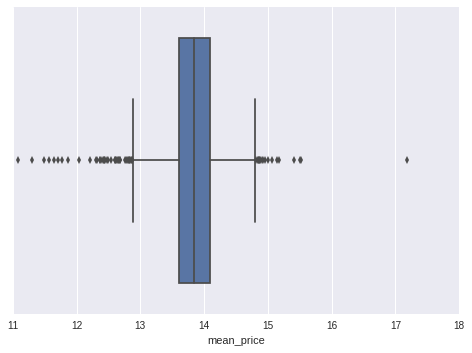

In [8]:
_ = sns.boxplot(x=ToU_users['mean_price'])

In [11]:
from scipy import stats
stats.percentileofscore(ToU_users['mean_price'],14.228)

85.317815577439575

85% of the users paid less for their kWh than the standard flat rate tariff user. It is possible than some of these did not really react to tariff changes, but it is clear that the remaining 15% did not react to dToU.

In [14]:
ToU_users['mean_price'].describe()/std_price

count    78.507169
mean      0.971168
std       0.034655
min       0.778791
25%       0.956065
50%       0.972676
75%       0.990080
max       1.207656
Name: mean_price, dtype: float64

The median dToU user paid 2.7% per kWh. Mean and median values are close to each other, but there are more outliers in the lower range than in the upper one. The smartest user paid over 28% less for his consumption!

##### Now we will investigate whether different socioeconomic consumer groups respond in different ways to the same dynamic tariff.

ACORN is a socioeconomic segmentation which attempts to describe customer behaviour used in the UK. There are 6 top-level groups which are further segregated into the lower-level segments defined by a letter as we have in our dataset. These are defined as follows:

Affluent Achievers:

-A: Lavish Lifestyles

-B: Executive Wealth

-C: Mature Money


Rising Prosperity:

-D: City Sophisticates

-E: Career Climbers


Comfortable Communities:

-F: Countryside Communities

-G: Successful Suburbs

-H: Steady Neighbourhoods

-I: Comfortable Seniors

-J: Starting Out


Financially Stretched:

-K: Student Life

-L: Modest means

-M: Striving Families

-N: Poorer Pensioners


Urban Adversity

-O: Young Hardship

-P: Struggling Estates

-Q: Difficult Circumstances


Not Private Households:

-R: Not Private Households

For more information refer to:
http://acorn.caci.co.uk/downloads/Acorn-User-guide.pdf

In [26]:
ACORN_levels = ToU_users['ACORN'].unique()

In [28]:
ACORN_levels.sort()
ACORN_levels

array(['ACORN-', 'ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'ACORN-Q',
       'ACORN-U'], dtype=object)

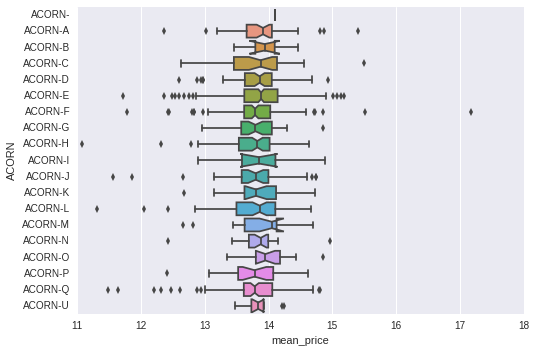

In [29]:
_ = sns.boxplot(x='mean_price', y='ACORN', data=ToU_users, order = ACORN_levels, notch = True)

In [61]:
ACORN_price = ToU_users.groupby('ACORN')['mean_price'].describe().unstack(level=1)
ACORN_price

,count,mean,std,min,25%,50%,75%,max
ACORN,,,,,,,,
ACORN-,1.0,14.106420,NaN,14.106420,14.106420,14.106420,14.106420,14.106420
ACORN-A,39.0,13.895414,0.519119,12.368000,13.656511,13.913826,14.053020,15.408785
ACORN-B,4.0,13.951253,0.411142,13.461324,13.793319,13.939159,14.097093,14.465370
ACORN-C,34.0,13.798230,0.547480,12.621159,13.456766,13.875074,14.133313,15.498438
ACORN-D,73.0,13.835792,0.411399,12.595315,13.628556,13.859890,14.051135,14.928961
ACORN-E,338.0,13.865832,0.460832,11.711281,13.620310,13.884152,14.142797,15.179523
ACORN-F,151.0,13.813675,0.516405,11.775736,13.617926,13.789527,14.027534,17.182524
ACORN-G,47.0,13.788401,0.338923,12.952387,13.572028,13.795620,14.052287,14.846828
ACORN-H,83.0,13.737643,0.522644,11.080637,13.534704,13.825183,14.017218,14.639255


In [46]:
ACORN_stats['mean'].sort_values()[:3]

ACORN
ACORN-J    13.723183
ACORN-H    13.737643
ACORN-L    13.751310
Name: mean, dtype: float64

In [56]:
ACORN_stats['50%'].sort_values()[:3]

ACORN
ACORN-P    13.780527
ACORN-Q    13.783004
ACORN-F    13.789527
Name: 50%, dtype: float64

In [57]:
ACORN_stats['50%'].sort_values(ascending=False)[:3]

ACORN
ACORN-     14.106420
ACORN-M    14.049996
ACORN-O    13.952387
Name: 50%, dtype: float64

In [54]:
ACORN_stats['25%'].sort_values()[:3]

ACORN
ACORN-C    13.456766
ACORN-L    13.497138
ACORN-P    13.523571
Name: 25%, dtype: float64

In [59]:
ACORN_stats['25%'].sort_values(ascending=False)[:3]

ACORN
ACORN-     14.106420
ACORN-O    13.801162
ACORN-B    13.793319
Name: 25%, dtype: float64

In [55]:
ACORN_stats['75%'].sort_values()[:3]

ACORN
ACORN-U    13.922001
ACORN-N    13.996473
ACORN-J    13.999242
Name: 75%, dtype: float64

In [53]:
ACORN_stats['std'].sort_values(ascending=False)[:5]

ACORN
ACORN-J    0.699752
ACORN-I    0.609306
ACORN-M    0.559435
ACORN-L    0.555139
ACORN-C    0.547480
Name: std, dtype: float64

In [49]:
ACORN_stats['min'].sort_values()[:3]

ACORN
ACORN-H    11.080637
ACORN-L    11.307295
ACORN-Q    11.486705
Name: min, dtype: float64

In [50]:
ACORN_stats['max'].sort_values(ascending=False)[:3]

ACORN
ACORN-F    17.182524
ACORN-C    15.498438
ACORN-A    15.408785
Name: max, dtype: float64

The lowest media is that P, Q and F groups. P and Q are low income groups.

-P is described as a mixture of poorer families with many children, low income terraced housing, multi-ethnic, purpose-built estates and low income families in social rented semis.

-Q users are single parents and families in social rented flats, singles and young families (some receiving benefits) and people living in deprived areas and high-rise flats.

Both of these groups have several outliers in the lower part of the mean price spectrum but only one in the higher part. Their maximum is 14.8 p/kWh, less than 0.6 above the standard flat rate tariff. These users are used to hardship and are prone to take any opportunity to save money.

-F users are countryside communities. These have a very large variability, with the top payer (nearly 3 p/kWh over the standard flat rate tariff) in this group.

-The worst group is M, with only 17 users (and some reacting very positively). These are a mixture of struggling young families in post-war terraces, people with limited means in post-war estates, semi-rural estates and families in right-to-buy estates. There is a large amount of lone parents, people enjoying benefits and lower than average internet, smartphone and tablet use.

-Group E has a large variability, with many outliers in the lower and upper ranges. It is composed by young career-driven families, first buyers and people living in mixed metropolitan areas. They are educated young people rising in prosperity, with heavy internet use (including online shopping). They own smartphones, tablets and other technological devices in a larger degree than the average British. Some have a strong positive reaction to dToU, others seem not to care about changing their consumption habits and end up paying more for their electricity.

-Group D is related to E and seems to behave in a more consistent way, although some users also to not react to the dynamic tariff. These are urban cosmopolitan young people, living in smaller flats and metropolitan areas.

In any case it seems the ACORN segmentation is not so effective to predict a user's behaviour, with all groups containing households that react and others than do not to the dToU tariff. It is true, however, that the less affluent groups do not have any of the top spenders among their ranks. These are presumably more compelled to save money from the meager incomes and take more care about profiting from a variable tariff.

It is very likely that other factors that cannot be known or even hinted at with our data influence consumer behaviour: his attitude towards the environment, hobbies (for example, a football fan will not defer his TV consumption even if the tariff is high) and working hours (dToU tariff was higher on average in the evening hours).

Let us examine now the consumption behaviour (regardless on the tariff of each group).

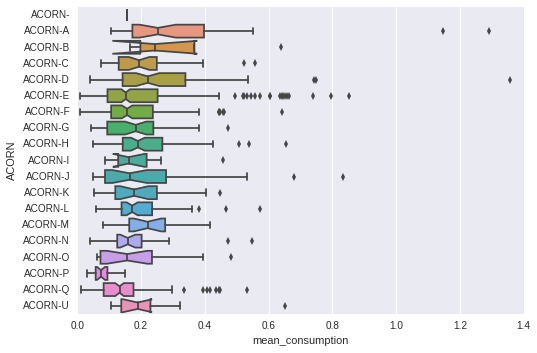

In [60]:
_ = sns.boxplot(x='mean_consumption', y='ACORN', data=ToU_users, order = ACORN_levels, notch = True)

In [62]:
ACORN_cons = ToU_users.groupby('ACORN')['mean_price'].describe().unstack(level=1)
ACORN_cons

,count,mean,std,min,25%,50%,75%,max
ACORN,,,,,,,,
ACORN-,1.0,14.106420,NaN,14.106420,14.106420,14.106420,14.106420,14.106420
ACORN-A,39.0,13.895414,0.519119,12.368000,13.656511,13.913826,14.053020,15.408785
ACORN-B,4.0,13.951253,0.411142,13.461324,13.793319,13.939159,14.097093,14.465370
ACORN-C,34.0,13.798230,0.547480,12.621159,13.456766,13.875074,14.133313,15.498438
ACORN-D,73.0,13.835792,0.411399,12.595315,13.628556,13.859890,14.051135,14.928961
ACORN-E,338.0,13.865832,0.460832,11.711281,13.620310,13.884152,14.142797,15.179523
ACORN-F,151.0,13.813675,0.516405,11.775736,13.617926,13.789527,14.027534,17.182524
ACORN-G,47.0,13.788401,0.338923,12.952387,13.572028,13.795620,14.052287,14.846828
ACORN-H,83.0,13.737643,0.522644,11.080637,13.534704,13.825183,14.017218,14.639255
